Ref: https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = [12, 6]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################
plt.rcParams.update({'axes.grid'     : True})

## Import data

In [3]:
data = pd.read_csv('../data/num_file/min_05/p040.csv')

In [4]:
print(data)

                  datetime  count
0      2022-04-21 01:40:00    200
1      2022-04-21 01:45:00      0
2      2022-04-21 01:50:00    241
3      2022-04-21 01:55:00    592
4      2022-04-21 02:00:00     27
...                    ...    ...
38995  2022-09-03 11:15:00   1042
38996  2022-09-03 11:20:00   1913
38997  2022-09-03 11:25:00   2024
38998  2022-09-03 11:30:00   2006
38999  2022-09-03 11:35:00   2170

[39000 rows x 2 columns]


If there is no people, use NaN.

In [5]:
data.loc[data['count']==0, 'count'] = np.NaN

In [6]:
print(data)

                  datetime   count
0      2022-04-21 01:40:00   200.0
1      2022-04-21 01:45:00     NaN
2      2022-04-21 01:50:00   241.0
3      2022-04-21 01:55:00   592.0
4      2022-04-21 02:00:00    27.0
...                    ...     ...
38995  2022-09-03 11:15:00  1042.0
38996  2022-09-03 11:20:00  1913.0
38997  2022-09-03 11:25:00  2024.0
38998  2022-09-03 11:30:00  2006.0
38999  2022-09-03 11:35:00  2170.0

[39000 rows x 2 columns]


<Axes: >

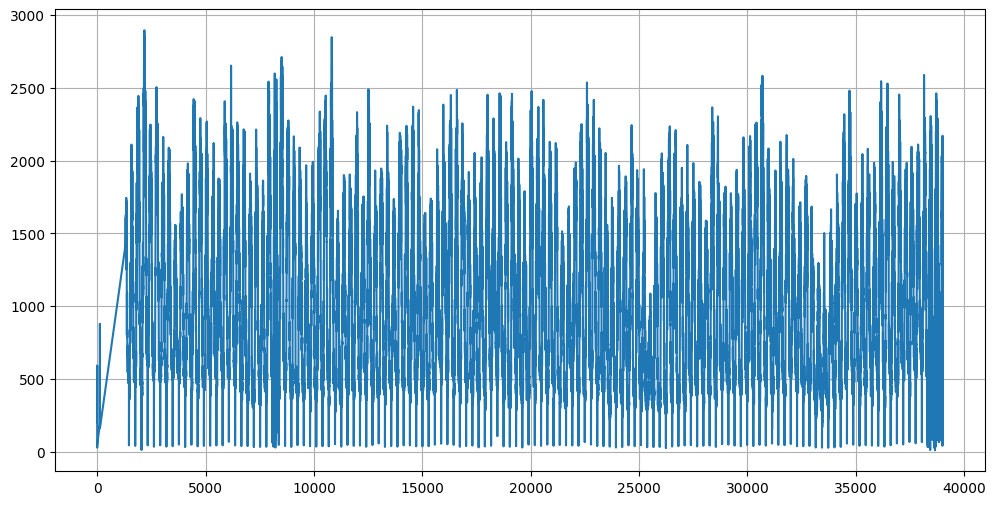

In [7]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

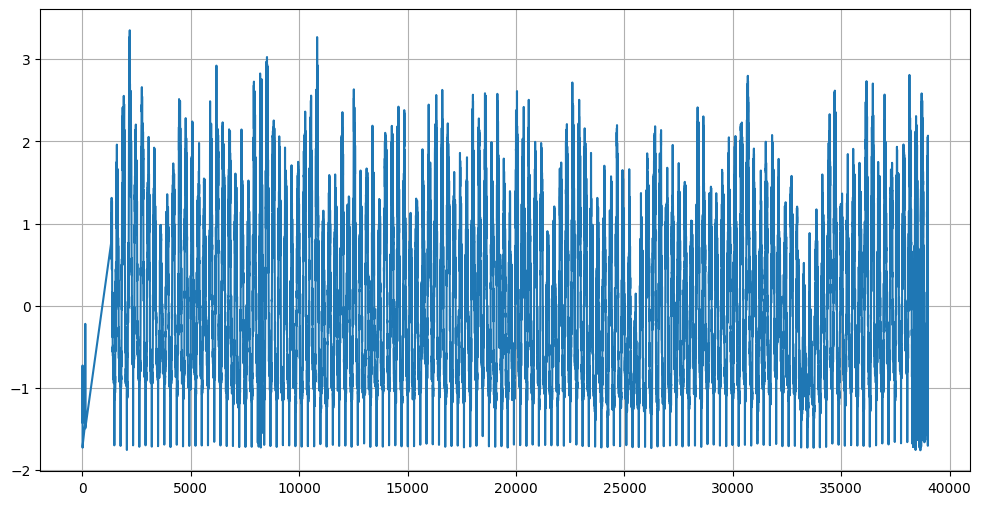

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [9]:
print(data)

                  datetime     count
0      2022-04-21 01:40:00 -1.420353
1      2022-04-21 01:45:00 -1.384071
2      2022-04-21 01:50:00 -1.347789
3      2022-04-21 01:55:00 -0.726571
4      2022-04-21 02:00:00 -1.726537
...                    ...       ...
38995  2022-09-03 11:15:00  0.069861
38996  2022-09-03 11:20:00  1.611400
38997  2022-09-03 11:25:00  1.807854
38998  2022-09-03 11:30:00  1.775996
38999  2022-09-03 11:35:00  2.066252

[39000 rows x 2 columns]


In [10]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 12

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [11]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [12]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

## Model

In [13]:
from keras.layers import Input, LSTM, BatchNormalization, RepeatVector, TimeDistributed, Dense, dot, multiply, concatenate, Activation, GRU
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [14]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [15]:
'''
lstm_1 = LSTM(32, return_sequences=True, return_state=False)(input_train)
norm_lstm_1 = BatchNormalization()(lstm_1)
'''

'\nlstm_1 = LSTM(32, return_sequences=True, return_state=False)(input_train)\nnorm_lstm_1 = BatchNormalization()(lstm_1)\n'

In [16]:
# encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, activation='relu', return_sequences=False, return_state=True)(input_train)
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, return_sequences=False, return_state=True)(input_train)

In [17]:
encoder_last_h1 = BatchNormalization()(encoder_last_h1)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [18]:
decoder = RepeatVector(time_step)(encoder_last_h1)
# decoder = LSTM(32, activation='relu', return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])
decoder = LSTM(32, return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

In [19]:
# lstm_decode = LSTM(32, return_sequences=True, return_state=False)(decoder)

In [20]:
out = TimeDistributed(Dense(1))(decoder)

In [21]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 32),         4352        ['input_1[0][0]']                
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 batch_normalization (BatchNorm  (None, 32)          128         ['lstm[0][0]']                   
 alization)                                                                                   

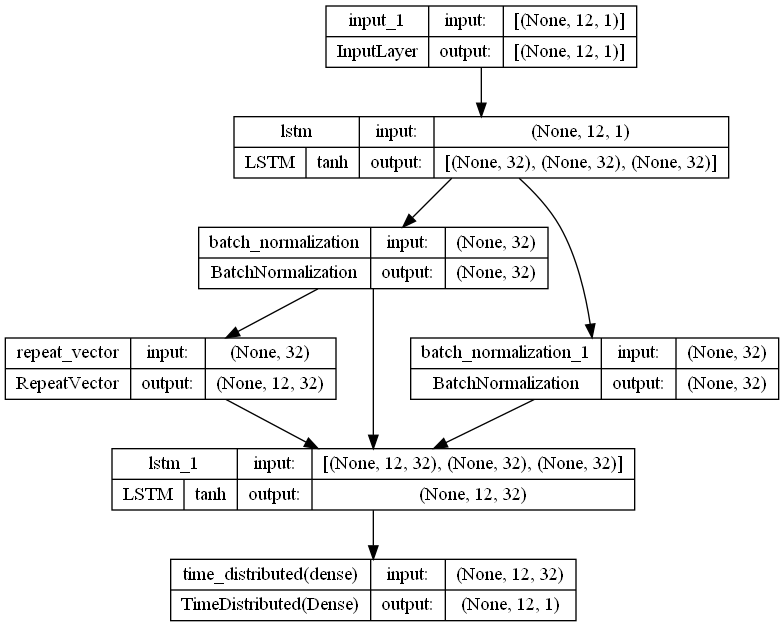

In [22]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_activations=True)

In [23]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es], shuffle=True)

Epoch 1/100
220/220 [==============================] - 3s 7ms/step - loss: 0.0420 - mae: 0.1411 - val_loss: 0.0659 - val_mae: 0.2140
Epoch 2/100
220/220 [==============================] - 1s 5ms/step - loss: 0.0305 - mae: 0.1237 - val_loss: 0.0433 - val_mae: 0.1586
Epoch 3/100
220/220 [==============================] - 1s 5ms/step - loss: 0.0248 - mae: 0.1105 - val_loss: 0.0246 - val_mae: 0.1141
Epoch 4/100
220/220 [==============================] - 1s 5ms/step - loss: 0.0218 - mae: 0.1025 - val_loss: 0.0253 - val_mae: 0.1214
Epoch 5/100
220/220 [==============================] - 1s 5ms/step - loss: 0.0208 - mae: 0.1014 - val_loss: 0.0212 - val_mae: 0.1114
Epoch 6/100
220/220 [==============================] - 1s 5ms/step - loss: 0.0181 - mae: 0.0933 - val_loss: 0.0172 - val_mae: 0.0966
Epoch 7/100
220/220 [==============================] - 1s 5ms/step - loss: 0.0179 - mae: 0.0934 - val_loss: 0.0180 - val_mae: 0.0974
Epoch 8/100
220/220 [==============================] - 1s 5ms/step - 

In [24]:
# model.save('./params/p040_seq2seq.keras')

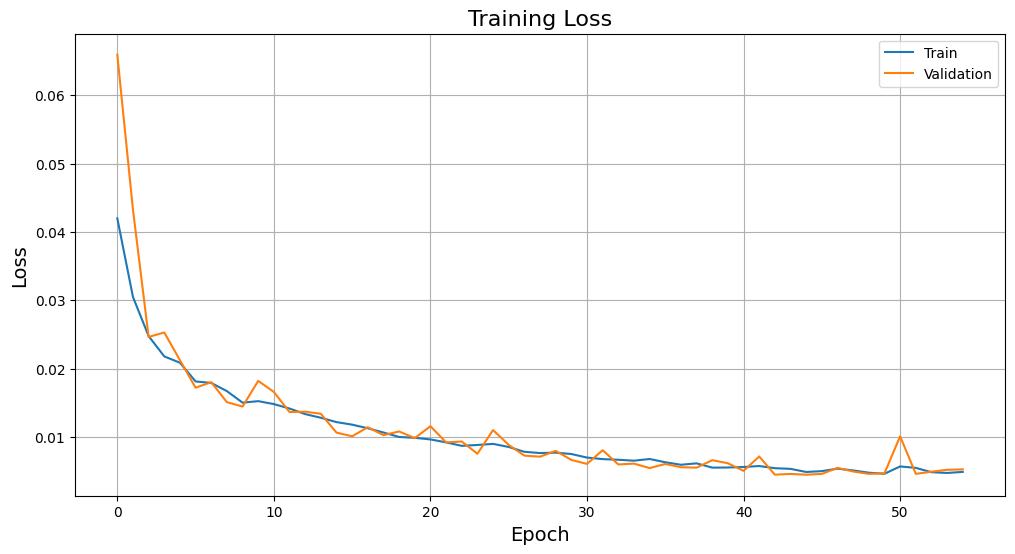

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [26]:
predict_train = model.predict(encode_input_data_train)

975/975 [==============================] - 2s 2ms/step


In [27]:
predict_test = model.predict(encode_input_data_test)

244/244 [==============================] - 0s 2ms/step


In [28]:
print(predict_train.shape)

(31189, 12, 1)


In [29]:
print(predict_test.shape)

(7798, 12, 1)


In [30]:
predict = np.concatenate([predict_train, predict_test], axis=0)
print(predict.shape)

(38987, 12, 1)


In [31]:
print(predict_test[:, -1, :])

[[-0.34394515]
 [-0.2321018 ]
 [-0.33498555]
 ...
 [-0.0023682 ]
 [ 0.8546032 ]
 [ 0.8249481 ]]


In [32]:
print(decode_output_data_test[:, -1, :])

[[-0.32658531]
 [-0.47348285]
 [-0.41153811]
 ...
 [ 1.6114003 ]
 [ 1.80785364]
 [ 1.77599634]]


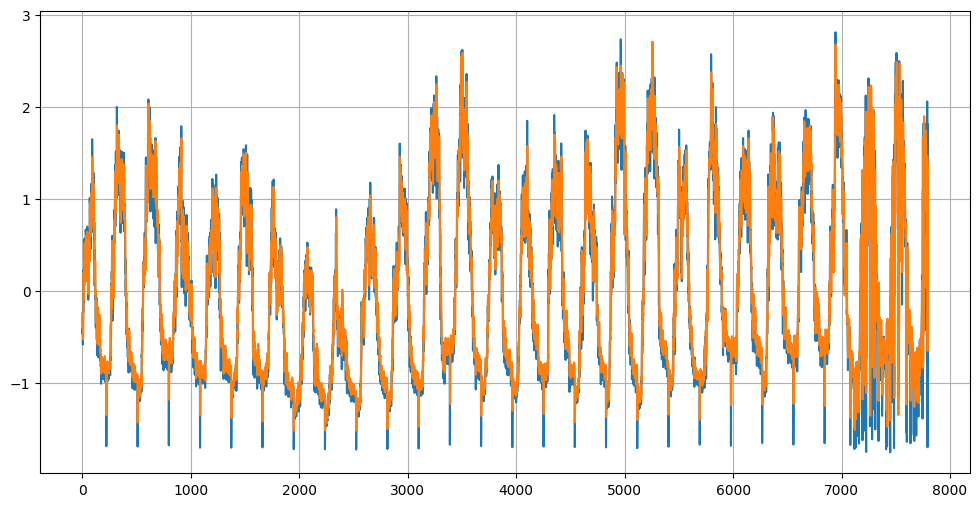

In [33]:
plt.plot(np.arange(decode_output_data_test.shape[0]), decode_output_data_test[:, -1, :])
plt.plot(np.arange(predict_test.shape[0]), predict_test[:, -1, :])
plt.show()

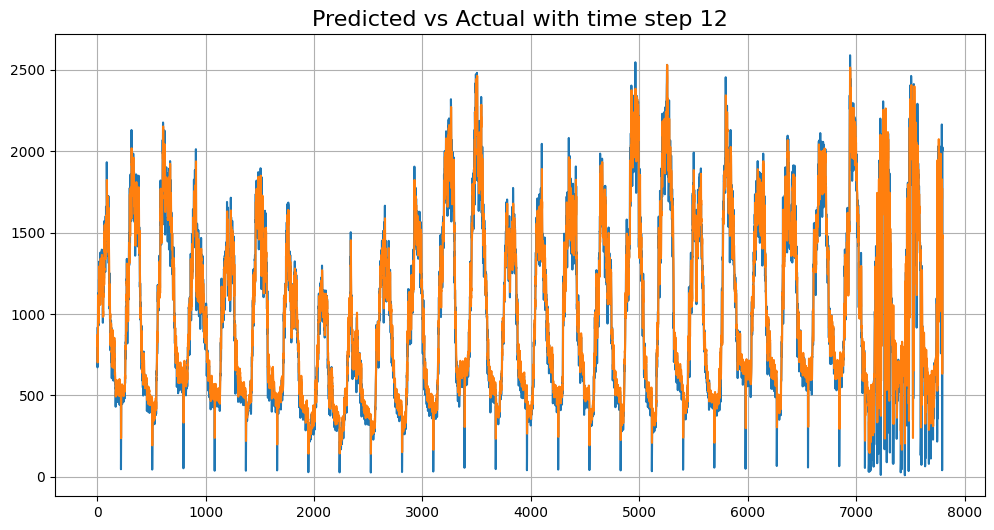

In [37]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'Predicted vs Actual with time step {time_step}')
plt.show()

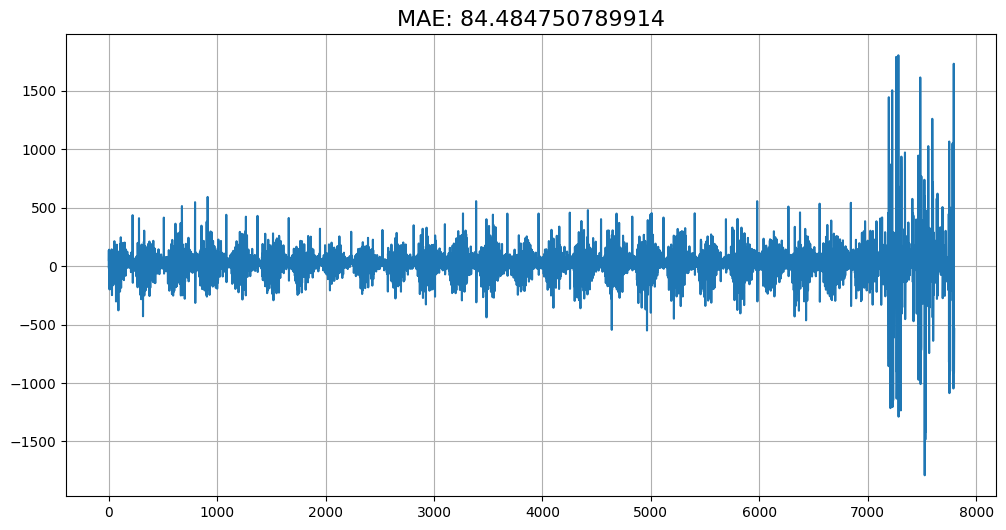

In [38]:
from sklearn.metrics import mean_absolute_error
plt.title('MAE: {}'.format(mean_absolute_error(decode_output_test_data, predict_test_data)))
plt.plot(np.arange(decode_output_test_data.shape[0]), predict_test_data-decode_output_test_data)
plt.show()